In [1]:
# !pip install gensim

In [1]:
import re
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec

In [ ]:
# !mkdir /root/.kaggle/
# !cp ./kaggle.json /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

# !kaggle datasets download -d venky73/spam-mails-dataset
!curl -L -o ./spam-mails-dataset.zip https://www.kaggle.com/api/v1/datasets/download/venky73/spam-mails-dataset
!unzip spam-mails-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/venky73/spam-mails-dataset
License(s): CC0-1.0
  0% 0.00/1.86M [00:00<?, ?B/s]
100% 1.86M/1.86M [00:00<00:00, 933MB/s]
Archive:  spam-mails-dataset.zip
  inflating: spam_ham_dataset.csv    


### for all task you may neet to remove:
  - punctuations, numbers, htmls tag, URLs
  - extra whitespace: text = re.sub(r'\s+', ' ', text).strip()

### Classification need heavy cleaning (lemmatization, stopword removal, lowercasing).
  - maybe you need to remove numbers and keep certain stop words like "no, not,never"
  - **sentiment_analysis**: cleaned = re.sub(r'[^\w\s!?]', ' ', cleaned)  # Keep ! and ?
  - **topic_classification**: remove stopword --> lemmatization **(TF-IDF often better)**
  - **spam_detection**: cleaned = re.sub(r'[^\w\s!$%&]', ' ', cleaned) # keep !$%&

### Retrieval need light cleaning (normalize whitespace, maybe lemmatize, but keep stopwords and numbers).

```python
if language in ['chinese', 'japanese', 'thai']:
        import jieba
        tokens = jieba.lcut(text)
        return ' '.join(tokens)
elif language in ['arabic', 'hebrew']:
    # Handle right-to-left languages
    text = text.strip()
```

In [4]:
# !python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
pd.set_option("display.max_columns", None)
df = pd.read_csv("spam_ham_dataset.csv", index_col = "Unnamed: 0")
print(df.columns)

df = df[['text', 'label']]
df['label'] = df['label'].map({"ham": 0, "spam": 1})

df.head()

Index(['label', 'text', 'label_num'], dtype='object')


,text,label
605,Subject: enron methanol ; meter # : 988291\r\n...,0
2349,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
3624,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
4685,"Subject: photoshop , windows , office . cheap ...",1
2030,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
def removeStopPunc(sentence):
    sentence = re.sub(r"\s+", " ", sentence)
    keep = ["not", "no", "never"]
    stops = [w for w in list(STOP_WORDS) if not keep]
    sentence = nlp(sentence)
    sentence = [t.lemma_ for t in sentence if t not in stops and not t.is_punct and not t.is_digit]

    return sentence

In [8]:
tqdm.pandas()
df['tokenized'] = df['text'].progress_map(lambda sentence: removeStopPunc(sentence))

  0%|          | 0/5171 [00:00<?, ?it/s]

In [ ]:
class CallBacks(tqdm):
    def __init__(self, epochs, **kwargs):
        super().__init__(total = epochs, desc = 'Training', **kwargs)
        self.epoch = 0

    def on_epoch_begin(self, model):
        pass

    def on_epoch_end(self, model):
        self.epoch += 1
        self.update(1)

    def on_train_begin(self, model):
        pass
    
    def on_train_end(self, model):
        self.close()

In [ ]:
epochs = 100
progress = CallBacks(epochs)
# Train Word2Vec model
# sg : Training algorithm: 1 for skip-gram; otherwise CBOW.
# hs : If 1, use softmax. If 0, without softmax

model = Word2Vec(
    sentences = df["tokenized"], # tokenized sentences
    # sentences = df["text"],
    vector_size = 128,           # Dimension of word vectors
    window = 5,                  # Context window size
    min_count = 3,               # Ignore words with frequency < min_count
    workers = 4,                 # Number of CPU cores
    epochs = epochs,                # Number of training iterations
    callbacks = [progress]
)


# model = Word2Vec(
#     sentences = df["tokenized"],
#     vector_size=100,
#     window=5,
#     min_count=1,
#     workers=4,
#     sg=1,                      # Use Skip-gram (better for small datasets)
#     hs=0,                      # Use negative sampling
#     negative=5,                # Number of negative samples
#     ns_exponent=0.75,          # Negative sampling exponent
#     alpha=0.025,               # Initial learning rate
#     min_alpha=0.0001,          # Minimum learning rate
#     epochs=100
# )

In [10]:
# Get word vector for a specific word
vector = model.wv['machine']
print(f"Vector shape: {vector.shape}")
print(f"Vector for 'machine':\n{vector}")

Vector shape: (128,)
Vector for 'machine':
[-1.01261151e+00 -6.78360105e-01  1.28061306e+00  2.24969253e-01
 -2.05463096e-01  6.59947574e-01  1.10202944e+00  1.17142677e+00
 -1.35170472e+00 -1.55933607e+00  9.62853074e-01  4.03884143e-01
 -3.28442901e-01 -3.67344379e-01 -7.84671724e-01  9.21400964e-01
 -3.08366209e-01 -1.18717372e+00  7.57737756e-01  9.64290082e-01
  7.42272794e-01 -3.27805847e-01 -1.65820074e+00 -1.48749083e-01
  2.36018211e-01 -3.18037897e-01 -1.77184141e+00 -4.11237925e-01
 -1.35664308e+00  1.60777402e+00 -1.66987702e-01 -3.16130757e-01
  1.43661548e-03 -1.44307637e+00  1.48199749e+00 -6.75072670e-01
  7.98536777e-01 -3.11324261e-02 -1.23100293e+00 -1.08562744e+00
  1.09920073e+00  6.92802846e-01  3.40886295e-01 -6.23173416e-01
  1.04372835e+00  1.82657596e-02 -2.56795883e+00  9.11853239e-02
  1.22468174e+00  3.49298447e-01 -3.64497826e-02  2.51041627e+00
 -1.21111584e+00 -1.80384949e-01 -2.07033920e+00 -8.03497255e-01
 -2.65142083e+00  3.45368803e-01  6.25420451e-0

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(df['text'])
idf_dict = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

def document_vector(model, doc_tokens, TF_IDF = None):

    words = [w for w in doc_tokens if w in model.wv.key_to_index]
    if not words:
        return np.zeros(model.vector_size)
    if TF_IDF:
        weights = [idf_dict.get(w, 1.0) for w in words]
        return np.average([model.wv[w] for w in words], axis = 0, weights=weights)
    else:
        return np.mean([model.wv[w] for w in words], axis = 0)

In [14]:
X = df['tokenized'].progress_apply(lambda token: document_vector(model, token, idf_dict))
X = np.vstack(X.values)
y = np.reshape(df['label'], (-1, 1))

  0%|          | 0/5171 [00:00<?, ?it/s]

In [15]:
X.shape,  y.shape

((5171, 128), (5171, 1))

### Classify text

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
print("Accuracy:", pipeline.score(X_test, y_test))

In [ ]:
randomForest = RandomForestClassifier()
randomForest.fit(X_train, y_train)

y_pred = randomForest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       747
           1       0.95      0.97      0.96       288

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.97      0.97      1035



### Find similarity

In [20]:
def find_similar_texts(input_text, vectorized_texts, text, top_n = 3):
    input_text = removeStopPunc(input_text)
    input_vector = document_vector(model, input_text, idf_dict).reshape(1, -1)

    similarities = cosine_similarity(input_vector, vectorized_texts)[0]
    top_indicies = np.argsort(similarities)[::-1][:top_n]

    result = []
    for idx in top_indicies:
        result.append(
            {
                "idx": idx,
                "similarity": similarities[idx],
                "text": text[idx]
            }
        )

    return result

In [21]:
input_text = "Please attached that file and upload it to www.apple.com"

similarities = find_similar_texts(input_text, X, df['text'])
for result in similarities:
    print(f"Similarity: {result['similarity']:.4f} - Text: {result['text'][:100]}...")
    print()

Similarity: 0.8732 - Text: Subject: enron / hpl actuals for december 14 , 2000
teco tap 78 . 125 / hpl gas daily...

Similarity: 0.8701 - Text: Subject: updated spreadsheet
here is the lastest and greatest . please make sure that you look at t...

Similarity: 0.8018 - Text: Subject: cornhusker
where are we on the gas agreement for the cleburne plant ?...



### Pretrain Glove embedding

```py
import gensim.downloader as api

# Get detailed info about all models
model_info = api.info()
for model_name, info in model_info['models'].items():
    print(f"\n{model_name}:")
    print(f"  - Description: {info.get('description', 'N/A')}")
    print(f"  - File size: {info.get('file_size', 'N/A')}")
    print(f"  - Parameters: {info.get('parameters', 'N/A')}")
```

In [22]:
import gensim.downloader as api

# Load pre-trained GloVea
glove_model = api.load("glove-wiki-gigaword-100")  # 100-dim
# or: "glove-wiki-gigaword-200", "glove-wiki-gigaword-300", "glove-twitter-25", etc.

print(f"GloVe vocabulary size: {len(glove_model.key_to_index)}")

[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe vocabulary size: 400000


In [33]:
def document_vector_pretrained(model, doc_tokens, TF_IDF = None):
    words = [w for w in doc_tokens if w in model.key_to_index]

    if not words:
        return np.zeros(model.vector_size)
    if TF_IDF:
        weights = [idf_dict.get(w, 1.0) for w in words]
        return np.average([model[w] for w in words], axis=0, weights=weights)
    else:
        return np.mean([model[w] for w in words], axis=0)

X = df['tokenized'].progress_apply(lambda token: document_vector_pretrained(glove_model, token, idf_dict))
X = np.vstack(X.values)
y = np.reshape(df['label'], (-1, 1))

  0%|          | 0/5171 [00:00<?, ?it/s]

In [36]:
def find_similar_texts(input_text, vectorized_texts, text, top_n = 3):
    input_text = removeStopPunc(input_text)
    input_vector = document_vector_pretrained(glove_model, input_text, idf_dict).reshape(1, -1)

    similarities = cosine_similarity(input_vector, vectorized_texts)[0]
    top_indicies = np.argsort(similarities)[::-1][:top_n]

    result = []
    for idx in top_indicies:
        result.append(
            {
                "idx": idx,
                "similarity": similarities[idx],
                "text": text[idx]
            }
        )

    return result

input_text = "Please attached that file and upload it to www.apple.com"

similarities = find_similar_texts(input_text, X, df['text'])
for result in similarities:
    print(f"Similarity: {result['similarity']:.4f} - Text: {result['text']}...")
    print("*" * 100)

Similarity: 0.9129 - Text: Subject: enron / hpl actuals for december 14 , 2000
teco tap 78 . 125 / hpl gas daily...
****************************************************************************************************
Similarity: 0.9090 - Text: Subject: refill notification ref : dfo - 102056072
refill notification ref : mp - 01408304990
dear paliourg @ iit . demokritos . gr ,
our automated system has identified that you most likely are ready to refill your recent online pharmaceutical order .
to help you get your needed supply , we have sent this reminder notice .
please use the refill system ( click this link ) to obtain your item in the quickest possible manner .
thank you for your time and we look forward to assisting you .
sincerely ,
garland guthrie
metro snapshot forborne unix pathology clause linguist bike chill ancestry
dominick vade plagiarist warehouse tempt conway southernmost spa pottery
cottrell adept vest corridor doug ineradicable confound senor protozoa apostolic dusenbu

### Visualize how model seperate them

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)

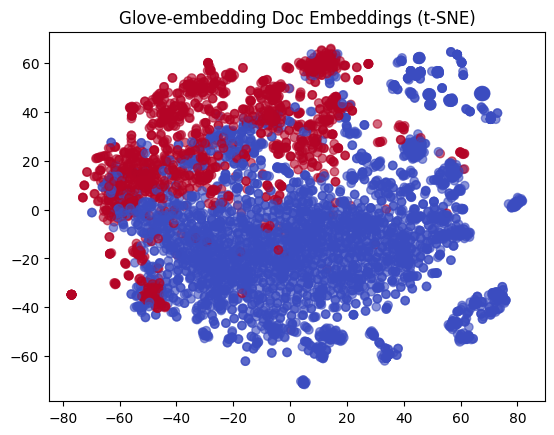

In [38]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = y.squeeze(), cmap = 'coolwarm', alpha = 0.6)
plt.title("Glove-embedding Doc Embeddings (t-SNE)")
plt.show()

### Other languages

Pretrained embeddings like GloVe or Word2Vec GoogleNews are English-only.

👉 That’s where Hugging Face Transformers (BERT, XLM-R, mBERT, etc.) shine. They’re trained on multilingual corpora and can tokenize + embed across many languages.


Popular multilingual models

1.	mBERT (Multilingual BERT)
    - Supports 104 languages (including Chinese, Hindi, Persian).
    - Model card: `bert-base-multilingual-cased`.

2.	XLM-R (XLM-RoBERTa)
    - More powerful than mBERT.
    - Trained on 100 languages with CommonCrawl (2.5TB of text).
    - Model card: `xlm-roberta-base`.

3.	LaBSE (Language-Agnostic BERT Sentence Embeddings)
    - pecialized for cross-lingual semantic similarity (supports >100 languages).
    - Model card: `sentence-transformers/LaBSE`.

In [39]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load multilingual model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
text = ["سلام دنیا"]
tokenizer.src_lang = "fa"
encoded = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

model.eval()
with torch.no_grad():
    outputs = model(**encoded)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # mean pooling

print("Embeddings shape:", embeddings.shape)
print("First embedding vector (Persian):", embeddings[0][:10])

Embeddings shape: torch.Size([1, 768])
First embedding vector (Persian): tensor([ 0.0651,  0.1442,  0.0011, -0.0200, -0.0118, -0.0077, -0.0138, -0.0215,
         0.0502, -0.1122])


In [ ]:
def document_vector_pretrained(model, tokenizer, doc_tokens):
    encode = tokenizer(doc_tokens, padding = True, truncation = True, return_tensors = "pt")

    with torch.no_grad():
        outputs = model(**encode)
        embeddings = outputs.last_hidden_state.mean(dim = 1)  # mean pooling

    return embeddings

# Load multilingual model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

X = df['tokenized'].progress_apply(lambda token: document_vector_pretrained(model, tokenizer, token))
X = np.vstack(X.values)
y = np.reshape(df['label'], (-1, 1))

In [ ]:
# Famous models
# BERT family
bert_models = ["bert-base-uncased", "bert-large-uncased"]

# RoBERTa family 
roberta_models = ["roberta-base", "roberta-large"]

# DistilBERT (smaller, faster)
distil_models = ["distilbert-base-uncased", "distilbert-base-cased"]

# DeBERTa (modern improvement)
deberta_models = ["microsoft/deberta-base", "microsoft/deberta-large"]

# For sequence classification specifically:
classification_models = [
    "bert-base-uncased",
    "distilbert-base-uncased-finetuned-sst-2-english",
    "cardiffnlp/twitter-roberta-base-sentiment-latest",
    "nlptown/bert-base-multilingual-uncased-sentiment"
]